# 2kr Assumptions Tests

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'calibration.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

showConstructedDF = True

# Fitting
distsFit = ['norm', 'uniform'] # Distributions to fit
distsParams = [(), ()] # Distributions params
outlierStddevDistance = 3 # Outliers identification

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for i, d in vecPerfIndexes:
    residualNames.append((i, d + ' (residuals)'))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(0, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Compute residuals

In [8]:
# coverage
scalars_wide['coveredUsersPercentMean'] = scalars_wide.groupby(factors)['coveredUsersPercent'].transform('mean')
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide.groupby(factors)['Floorplan.collisions:sum'].transform('mean')
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# vectors
skipped = []
for vecPerfIndex, _ in vecPerfIndexes:
    mean = scalars_wide.groupby(factors)[vecPerfIndex].transform('mean')
    nextVect = False
    for value in mean.values:
        if math.isinf(value):
            skipped.append(vecPerfIndex)
            nextVect = True
            continue
    if nextVect:
        continue
    scalars_wide[vecPerfIndex + 'Mean'] = mean
    scalars_wide[vecPerfIndex + 'Residual'] = scalars_wide[vecPerfIndex] - scalars_wide[vecPerfIndex + 'Mean']
for i, d in vecPerfIndexes:
    if i not in skipped:
        continue
    print(i + ' skipped due to infinite values in observations')
    residualNames.remove((i, d + ' (residuals)'))

broadcastTime75 skipped due to infinite values in observations
broadcastTime90 skipped due to infinite values in observations
broadcastTime95 skipped due to infinite values in observations


## Constructed DataFrame

In [9]:
if showConstructedDF:
    display(scalars_wide.describe())
    display(scalars_wide[(totalSims//2)-10:(totalSims//2)+10])
else:
    print('Skipping...')

qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,coveredUsersPercent,...,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,broadcastTime10Mean,broadcastTime10Residual,broadcastTime25Mean,broadcastTime25Residual,broadcastTime50Mean,broadcastTime50Residual
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.0,160.000000,160.000000,160.000000,...,160.000000,1.600000e+02,160.000000,1.600000e+02,160.000000,1.600000e+02,160.000000,1.600000e+02,160.000000,1.600000e+02
mean,7.500000,4.500000,17.500000,4.000000,4.500000,3.000000,500.0,474.681250,1004.975000,0.951265,...,0.951265,2.844947e-17,1004.975000,5.684342e-15,7.043750,7.216450e-17,16.606250,-1.221245e-16,26.200000,-3.996803e-16
std,4.624246,2.881299,7.523548,2.006279,2.507849,1.876703,0.0,37.816899,708.765939,0.075785,...,0.066929,3.555174e-02,694.307376,1.424304e+02,6.409601,2.611657e+00,10.023336,4.117687e+00,16.329932,5.936562e+00
min,0.000000,0.000000,10.000000,2.000000,2.000000,1.000000,500.0,266.000000,170.000000,0.533066,...,0.736673,-2.036072e-01,206.000000,-7.138000e+02,1.000000,-7.200000e+00,5.700000,-9.100000e+00,8.600000,-1.760000e+01
25%,3.750000,2.000000,10.000000,2.000000,2.000000,1.750000,500.0,467.750000,457.750000,0.937375,...,0.936122,-4.859719e-03,468.450000,-3.240000e+01,1.300000,-1.100000e+00,9.850000,-2.100000e+00,15.725000,-2.300000e+00
50%,7.500000,4.500000,17.500000,4.000000,4.500000,2.500000,500.0,491.500000,707.500000,0.984970,...,0.982565,8.016032e-04,799.100000,-2.350000e+00,5.150000,-3.000000e-01,13.450000,-4.500000e-01,20.250000,-3.000000e-01
75%,11.250000,7.000000,25.000000,6.000000,7.000000,3.750000,500.0,496.000000,1331.250000,0.993988,...,0.993086,7.064128e-03,1331.300000,3.370000e+01,10.675000,1.250000e-01,20.400000,1.625000e+00,32.075000,1.825000e+00
max,15.000000,9.000000,25.000000,6.000000,7.000000,6.000000,500.0,499.000000,2524.000000,1.000000,...,1.000000,1.450902e-01,2294.300000,4.362000e+02,18.200000,8.800000e+00,33.600000,1.930000e+01,54.200000,3.190000e+01


qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,coveredUsersPercent,...,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,broadcastTime10Mean,broadcastTime10Residual,broadcastTime25Mean,broadcastTime25Residual,broadcastTime50Mean,broadcastTime50Residual
run,,,,,,,,,,,,,,,,,,,,,
HighDensityCalibration-140-20210205-10:11:20-4341,7.0,0.0,10.0,6.0,7.0,6.0,500.0,499.0,353.0,1.000000,...,1.000000,0.000000,370.1,-17.1,16.9,2.1,32.8,-2.8,53.6,-12.6
HighDensityCalibration-141-20210205-10:11:21-4341,7.0,1.0,10.0,6.0,7.0,6.0,500.0,499.0,369.0,1.000000,...,1.000000,0.000000,370.1,-1.1,16.9,-1.9,32.8,-5.8,53.6,-2.6
HighDensityCalibration-142-20210205-10:11:21-4341,7.0,2.0,10.0,6.0,7.0,6.0,500.0,499.0,350.0,1.000000,...,1.000000,0.000000,370.1,-20.1,16.9,1.1,32.8,0.2,53.6,-0.6
HighDensityCalibration-143-20210205-10:11:22-4341,7.0,3.0,10.0,6.0,7.0,6.0,500.0,499.0,342.0,1.000000,...,1.000000,0.000000,370.1,-28.1,16.9,-4.9,32.8,-7.8,53.6,-17.6
HighDensityCalibration-144-20210205-10:11:22-4341,7.0,4.0,10.0,6.0,7.0,6.0,500.0,499.0,395.0,1.000000,...,1.000000,0.000000,370.1,24.9,16.9,-0.9,32.8,5.2,53.6,7.4
HighDensityCalibration-145-20210205-10:11:23-4341,7.0,5.0,10.0,6.0,7.0,6.0,500.0,499.0,360.0,1.000000,...,1.000000,0.000000,370.1,-10.1,16.9,-5.9,32.8,-5.8,53.6,-7.6
HighDensityCalibration-146-20210205-10:11:23-4341,7.0,6.0,10.0,6.0,7.0,6.0,500.0,499.0,406.0,1.000000,...,1.000000,0.000000,370.1,35.9,16.9,7.1,32.8,12.2,53.6,20.4
HighDensityCalibration-147-20210205-10:11:24-4341,7.0,7.0,10.0,6.0,7.0,6.0,500.0,499.0,396.0,1.000000,...,1.000000,0.000000,370.1,25.9,16.9,0.1,32.8,-1.8,53.6,-6.6
HighDensityCalibration-148-20210205-10:11:24-4341,7.0,8.0,10.0,6.0,7.0,6.0,500.0,499.0,388.0,1.000000,...,1.000000,0.000000,370.1,17.9,16.9,-4.9,32.8,2.2,53.6,7.4


## Residual distributions (histograms)

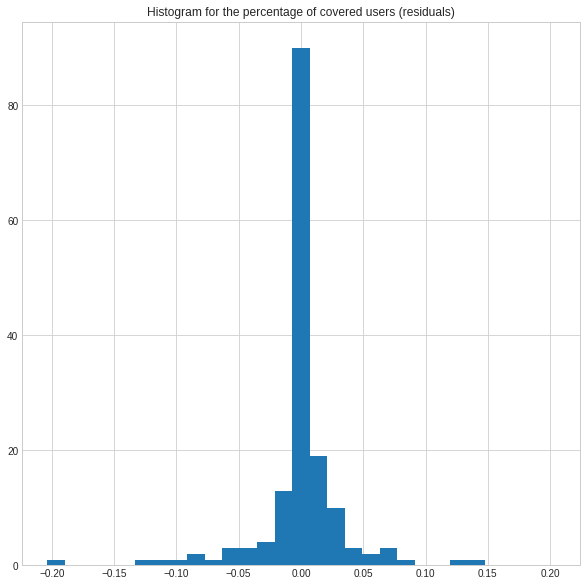

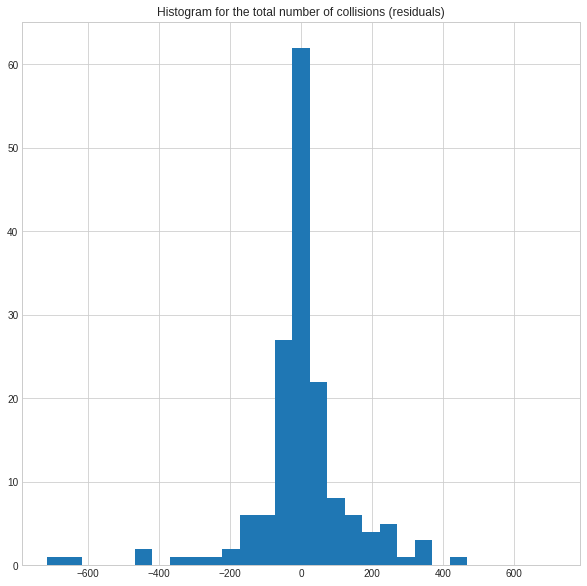

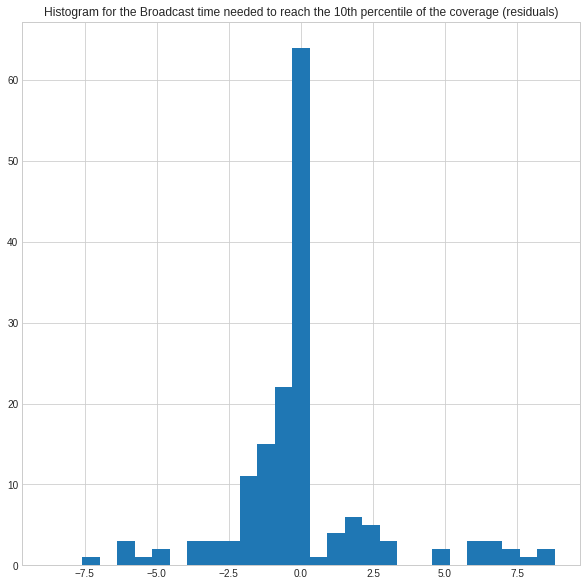

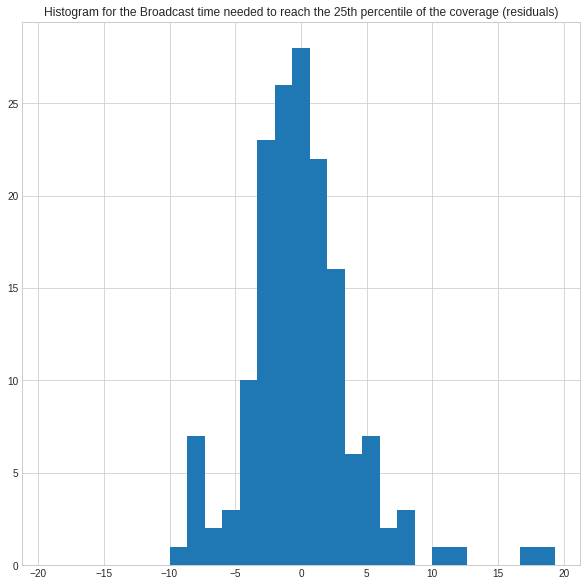

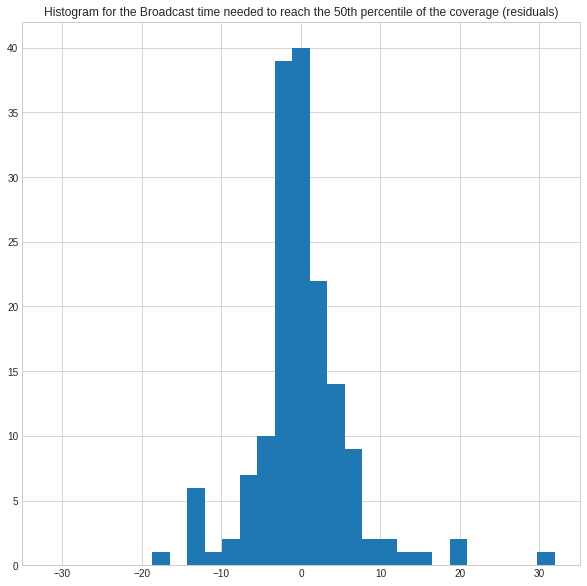

In [10]:
for varname, vardesc in residualNames:
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    minval = scalars_wide[varname + 'Residual'].min()
    maxval = scalars_wide[varname + 'Residual'].max()
    if histCenter:
        limit = max(abs(minval), abs(maxval))
        minval = -limit
        maxval = limit
    plt.hist(scalars_wide[varname + 'Residual'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
    plt.title('Histogram for the ' + vardesc)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-hist.png')
    plt.show()

## Distribution fitting

Trying to fit to a norm distribution:


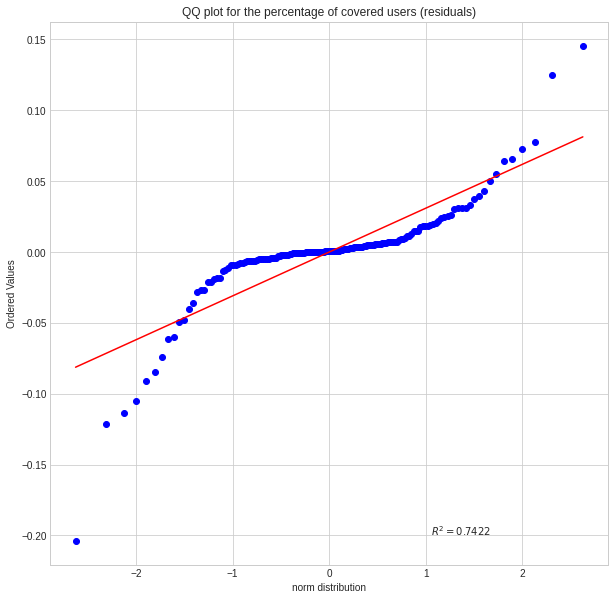

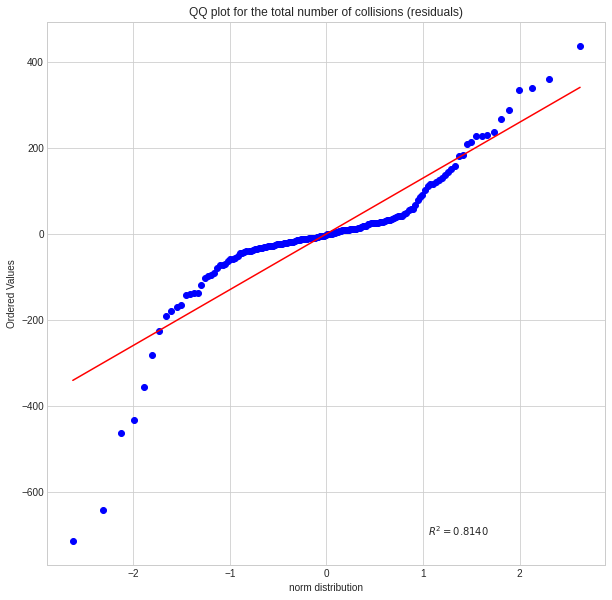

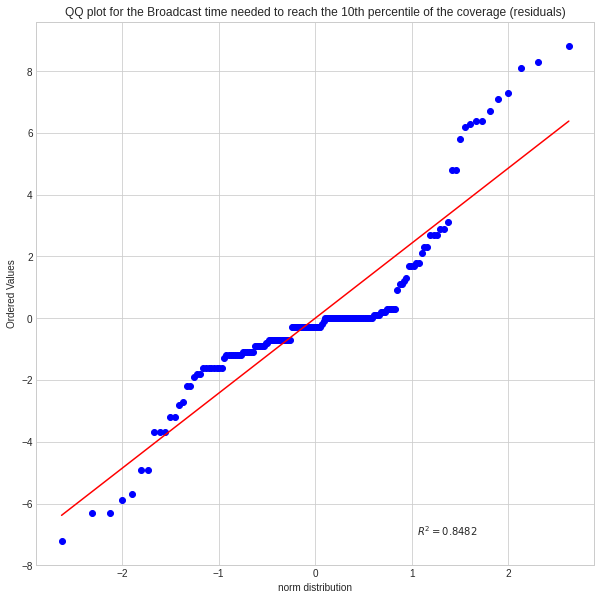

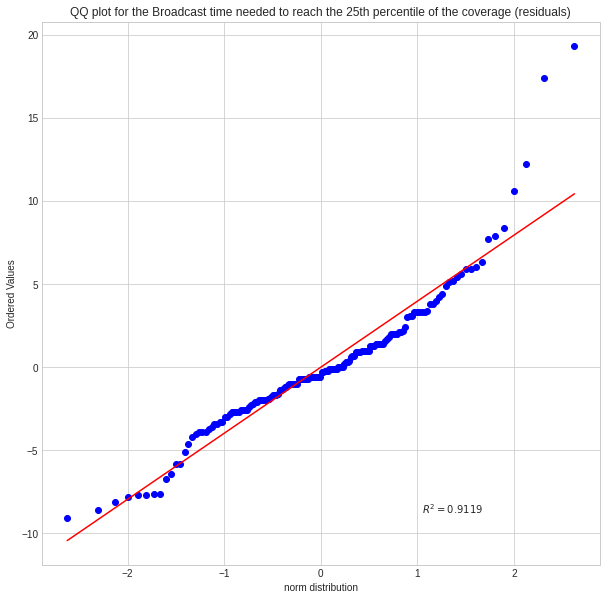

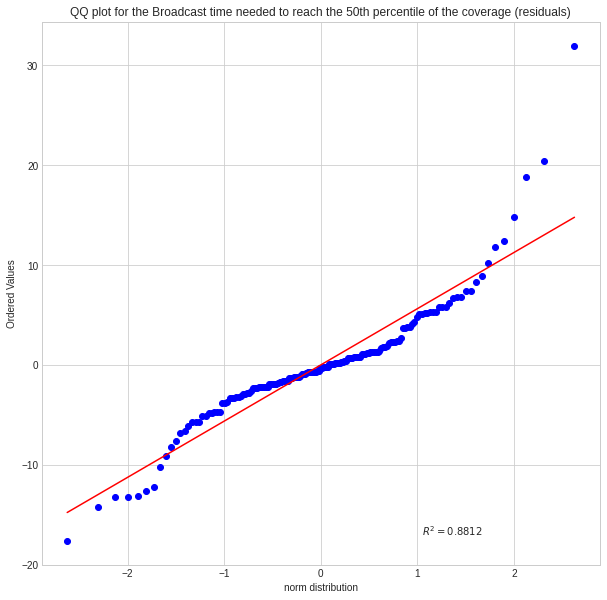

Trying to fit to a uniform distribution:


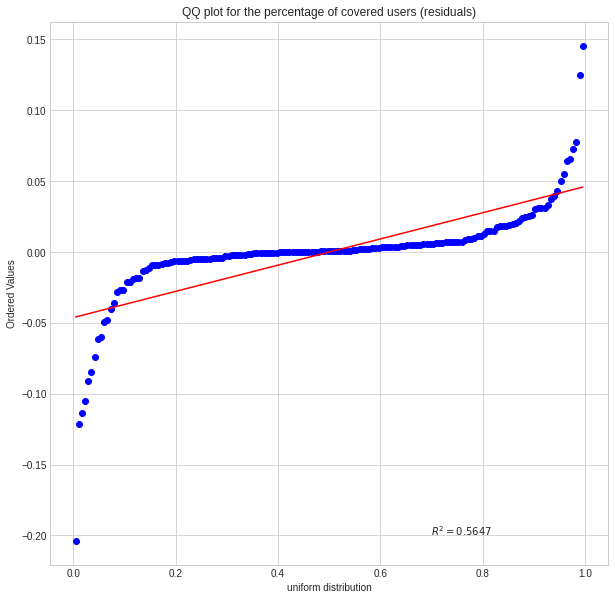

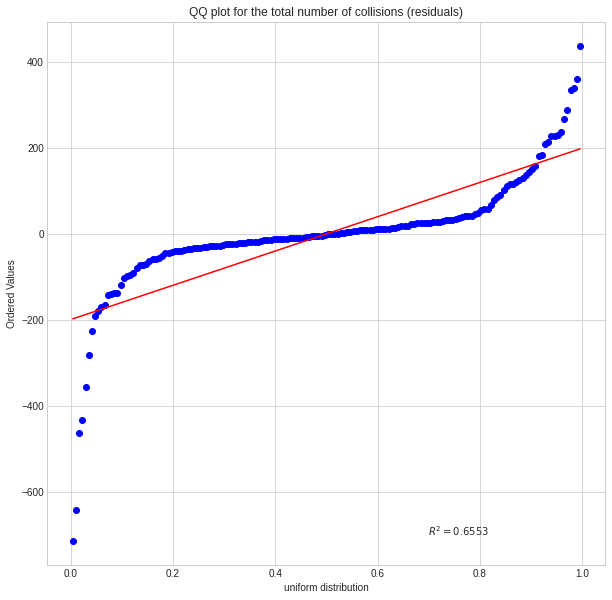

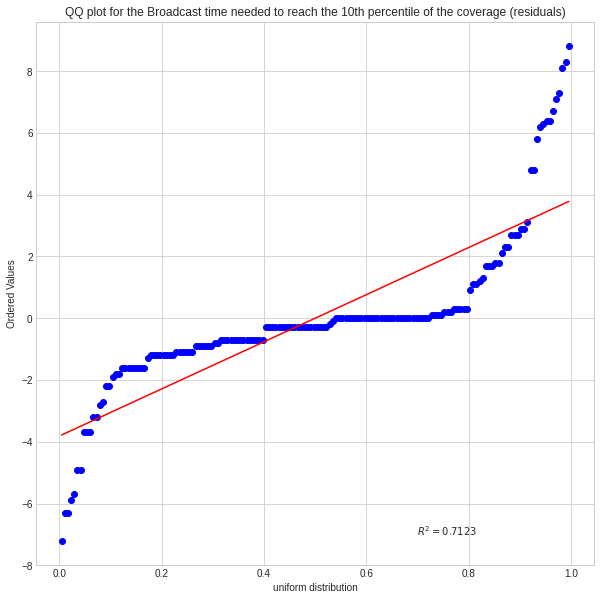

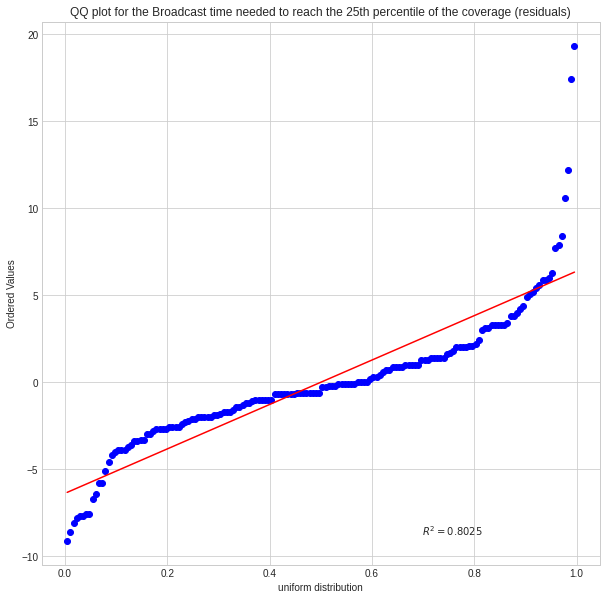

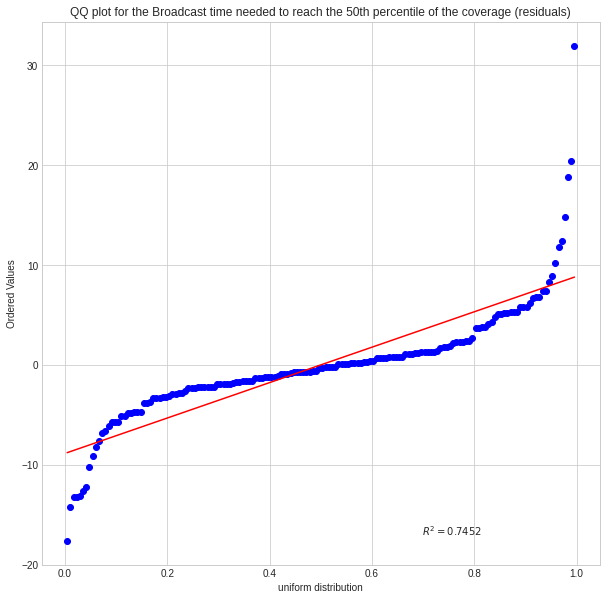

In [11]:
for distribution, params in zip(distsFit, distsParams):
    print('Trying to fit to a', distribution + ('({})'.format(', '.join(map(str, params))) if len(params) > 0 else ''), 'distribution:')
    for varname, vardesc in residualNames:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        residuals = scalars_wide[varname + 'Residual'].values.tolist()
        result, line = stats.probplot(residuals, dist=distribution, sparams=params, plot=plt, rvalue=True)
        #osm, _ = result
        #slope, intercept, _ = line
        plt.title("QQ plot for the " + vardesc)
        plt.xlabel(distribution + " distribution")
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(varname) + '-' + distribution + '-fit.png')
        plt.show()

### Outliers

In [12]:
for varname, vardesc in residualNames:
    print('Outliers for the ' + vardesc)
    stddev = scalars_wide[varname + 'Residual'].std()
    limit = outlierStddevDistance*stddev
    print('total mean:', scalars_wide[varname + 'Mean'].mean())
    print('stddev:', stddev)
    print(str(outlierStddevDistance) + '*stddev:', limit)
    outliers = scalars_wide[np.abs(scalars_wide[varname + 'Residual']) > limit]
    display(outliers[['config', 'repetition', *factors, varname + 'Residual', varname + 'Mean']])

Outliers for the percentage of covered users (residuals)
total mean: 0.9512650300601193
stddev: 0.035551738642090824
3*stddev: 0.10665521592627247


qname,config,repetition,R,T,m,D,coveredUsersPercentResidual,coveredUsersPercentMean
run,,,,,,,,
HighDensityCalibration-14-20210205-10:10:43-4341,8.0,4.0,25.0,2.0,2.0,1.0,0.145090,0.736673
HighDensityCalibration-15-20210205-10:10:43-4341,8.0,5.0,25.0,2.0,2.0,1.0,0.125050,0.736673
HighDensityCalibration-16-20210205-10:10:43-4341,8.0,6.0,25.0,2.0,2.0,1.0,-0.203607,0.736673
HighDensityCalibration-17-20210205-10:10:44-4341,8.0,7.0,25.0,2.0,2.0,1.0,-0.113427,0.736673
HighDensityCalibration-73-20210205-10:11:02-4341,11.0,3.0,25.0,2.0,7.0,2.0,-0.121042,0.884569


Outliers for the total number of collisions (residuals)
total mean: 1004.9749999999998
stddev: 142.43041774624922
3*stddev: 427.2912532387477


qname,config,repetition,R,T,m,D,collisionsResidual,collisionsMean
run,,,,,,,,
HighDensityCalibration-36-20210205-10:10:50-4341,10.0,6.0,25.0,2.0,7.0,1.0,-642.8,1965.8
HighDensityCalibration-37-20210205-10:10:51-4341,10.0,7.0,25.0,2.0,7.0,1.0,-713.8,1965.8
HighDensityCalibration-70-20210205-10:11:01-4341,11.0,0.0,25.0,2.0,7.0,2.0,436.2,1977.8
HighDensityCalibration-75-20210205-10:11:03-4341,11.0,5.0,25.0,2.0,7.0,2.0,-462.8,1977.8
HighDensityCalibration-76-20210205-10:11:03-4341,11.0,6.0,25.0,2.0,7.0,2.0,-432.8,1977.8


Outliers for the Broadcast time needed to reach the 10th percentile of the coverage (residuals)
total mean: 7.043749999999998
stddev: 2.611657465476883
3*stddev: 7.834972396430649


qname,config,repetition,R,T,m,D,broadcastTime10Residual,broadcastTime10Mean
run,,,,,,,,
HighDensityCalibration-123-20210205-10:11:17-4341,5.0,3.0,10.0,6.0,2.0,6.0,8.3,16.7
HighDensityCalibration-103-20210205-10:11:10-4341,6.0,3.0,10.0,6.0,7.0,3.0,8.8,18.2
HighDensityCalibration-149-20210205-10:11:24-4341,7.0,9.0,10.0,6.0,7.0,6.0,8.1,16.9


Outliers for the Broadcast time needed to reach the 25th percentile of the coverage (residuals)
total mean: 16.606249999999967
stddev: 4.117686961383745
3*stddev: 12.353060884151235


qname,config,repetition,R,T,m,D,broadcastTime25Residual,broadcastTime25Mean
run,,,,,,,,
HighDensityCalibration-123-20210205-10:11:17-4341,5.0,3.0,10.0,6.0,2.0,6.0,19.3,32.7
HighDensityCalibration-103-20210205-10:11:10-4341,6.0,3.0,10.0,6.0,7.0,3.0,17.4,33.6


Outliers for the Broadcast time needed to reach the 50th percentile of the coverage (residuals)
total mean: 26.2
stddev: 5.936561908680605
3*stddev: 17.809685726041813


qname,config,repetition,R,T,m,D,broadcastTime50Residual,broadcastTime50Mean
run,,,,,,,,
HighDensityCalibration-123-20210205-10:11:17-4341,5.0,3.0,10.0,6.0,2.0,6.0,31.9,53.1
HighDensityCalibration-103-20210205-10:11:10-4341,6.0,3.0,10.0,6.0,7.0,3.0,18.8,51.2
HighDensityCalibration-146-20210205-10:11:23-4341,7.0,6.0,10.0,6.0,7.0,6.0,20.4,53.6


## Independency test

qname,config,R,T,m,D
run,,,,,
HighDensityCalibration-0-20210205-10:10:39-4341,0.0,10.0,2.0,2.0,1.0
HighDensityCalibration-40-20210205-10:10:52-4341,1.0,10.0,2.0,2.0,2.0
HighDensityCalibration-20-20210205-10:10:44-4341,2.0,10.0,2.0,7.0,1.0
HighDensityCalibration-60-20210205-10:10:56-4341,3.0,10.0,2.0,7.0,2.0
HighDensityCalibration-80-20210205-10:11:04-4341,4.0,10.0,6.0,2.0,3.0
HighDensityCalibration-120-20210205-10:11:16-4341,5.0,10.0,6.0,2.0,6.0
HighDensityCalibration-100-20210205-10:11:09-4341,6.0,10.0,6.0,7.0,3.0
HighDensityCalibration-140-20210205-10:11:20-4341,7.0,10.0,6.0,7.0,6.0
HighDensityCalibration-10-20210205-10:10:42-4341,8.0,25.0,2.0,2.0,1.0


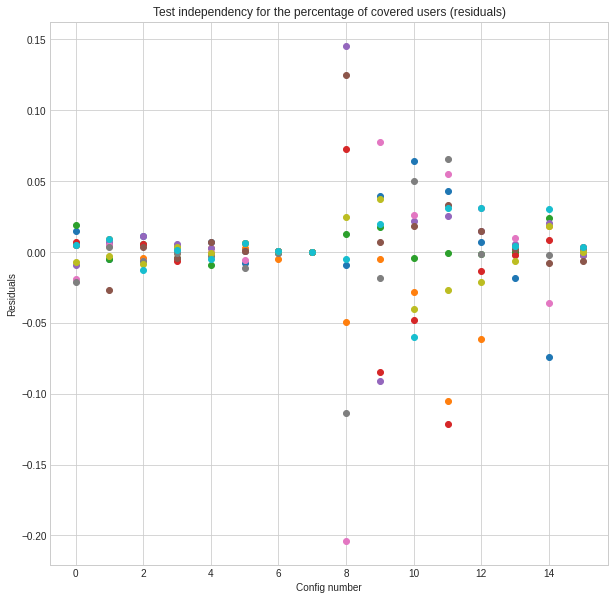

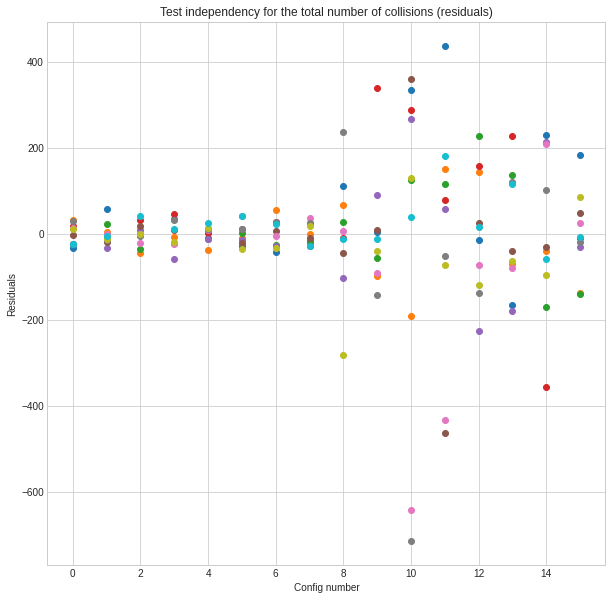

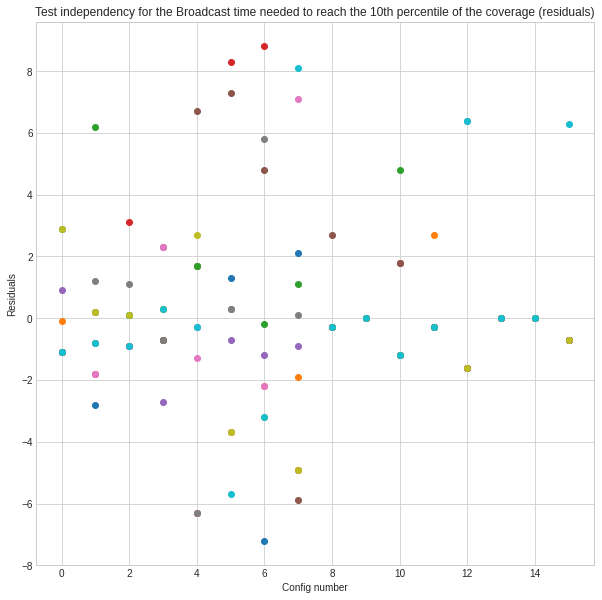

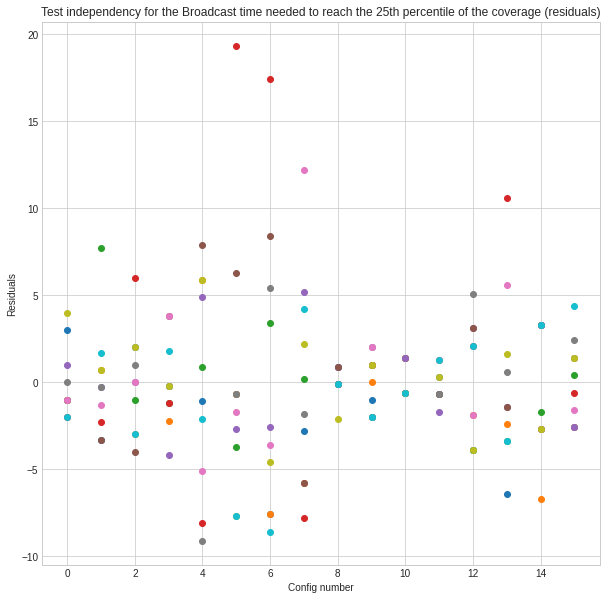

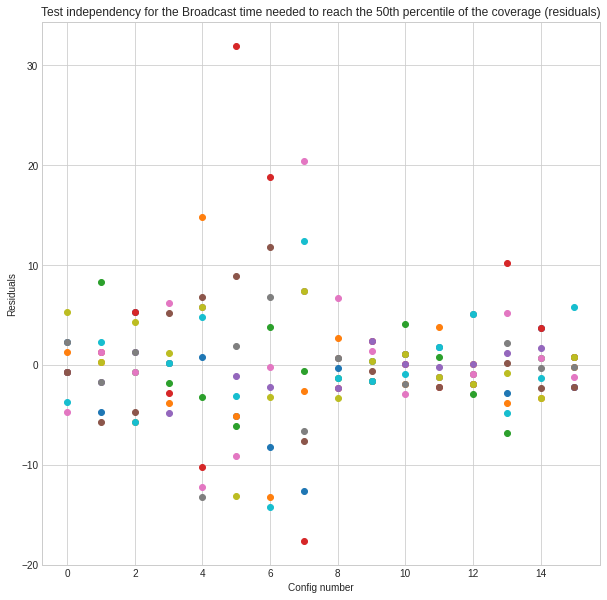

In [13]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-independency.png')
    plt.show()

## Finite variance test

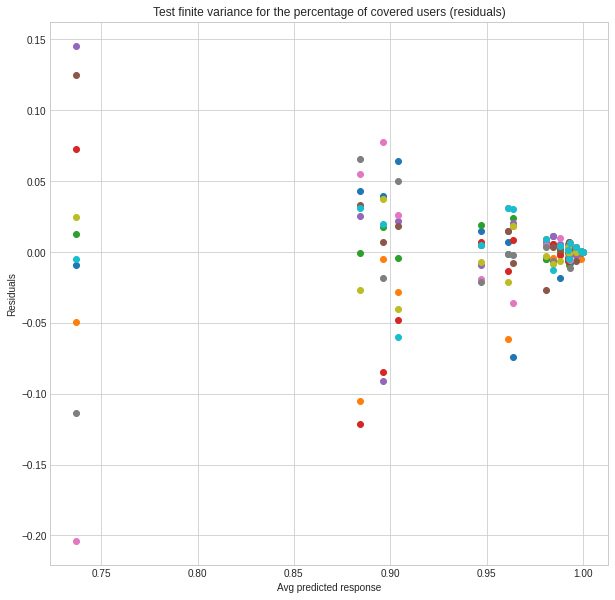

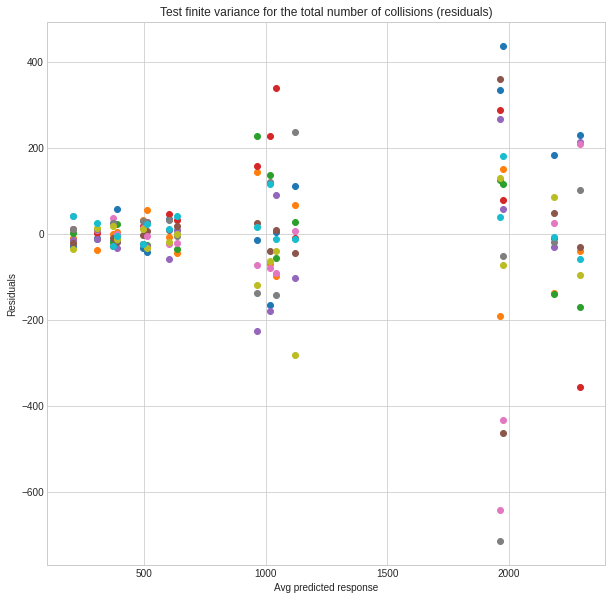

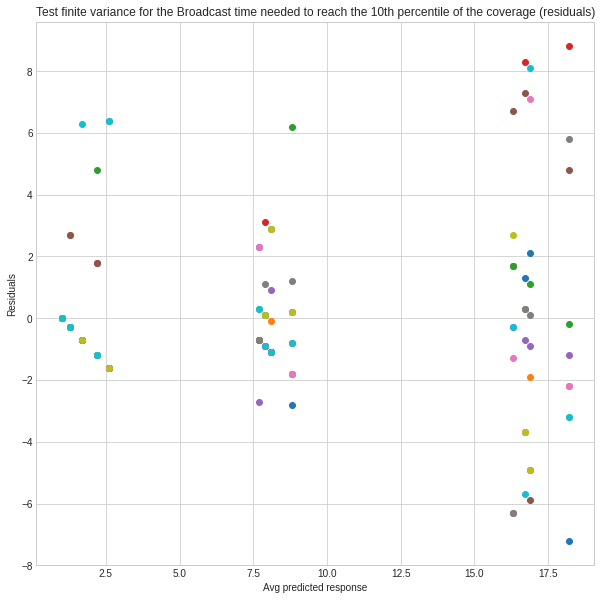

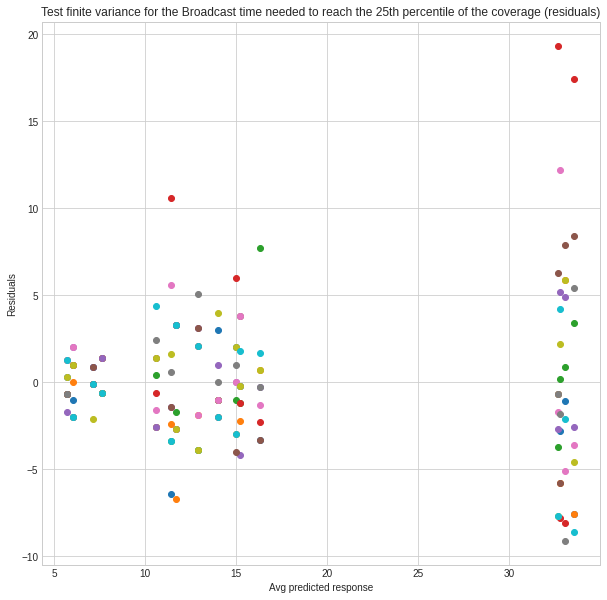

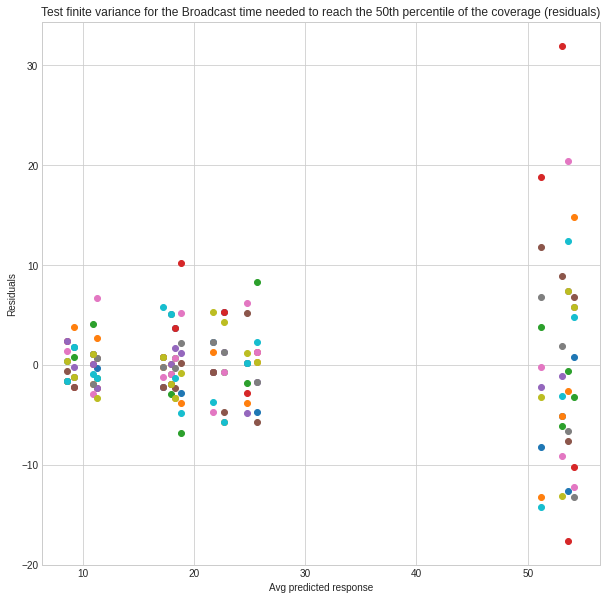

In [14]:
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Mean'].values.tolist())
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test finite variance for the " + vardesc)
    plt.xlabel("Avg predicted response")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(varname) + '-variance.png')
    plt.show()